<a href="https://colab.research.google.com/github/Samoh63/Machine-Learning/blob/main/SpecializationProject_MultipleFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
########################################
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# cross validaton grid search
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

##########################################
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

################### Feauture Selection ###############
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor

In [ ]:
# Code to read csv file into Colaboratory:
! gdown --id 1asJsP04zMhJcNQxDlX7QIrNWWKOFwmcu

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1asJsP04zMhJcNQxDlX7QIrNWWKOFwmcu
To: /content/StatistikkUttrekkForByggIÅlesundKommune.csv
100% 14.9M/14.9M [00:00<00:00, 226MB/s]


In [ ]:
data = pd.read_csv("/content/StatistikkUttrekkForByggIÅlesundKommune.csv")
data = data.drop(0, axis = 0)
# data

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,43,44,45,47,48,49,50,55,58,59,61,66,69,70,72,77,80,81,83,122,123,125,126,128,129,131,132,134,135,137,138,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 1) Preprocessing and cleaning data

In [ ]:
features_selected = data[[ 'Bygningskategori','Bygningstype', 'Byggeaar','Energikarakter', 'Oppvarmingskarakter', 'OppvarmetBRA', 'Materialvalg', 
                          'Oppvarmingstyper','VentilasjonssystemType',
                          # 'VarmepumpeType', 'VarmefordelingssystemVed',
                          'BeregnetLevertEnergiElektrisitetLokaltKlima_kWh']]
features_categorical =  [ 'Bygningskategori', 'Materialvalg', 'Oppvarmingstyper','VentilasjonssystemType','VarmepumpeType', 'VarmefordelingssystemVed']                       
# 'Energikarakter', 'Oppvarmingskarakter',
data['VarmefordelingssystemVed'].unique()

array(['Lukket peis eller ovn', 'Lukket peis', nan,
       'Lukket peis,Lukket vedovn', 'Lukket vedovn',
       'Lukket peis eller ovn,Åpen peis', 'Åpen peis',
       'Åpen peis,Lukket peis', 'Åpen peis,Lukket vedovn',
       'Ikke data for XML'], dtype=object)

In [ ]:
# The number of row without any output ()
data[data['BeregnetLevertEnergiElektrisitetLokaltKlima_kWh'] == 0].count()['BeregnetLevertEnergiElektrisitetLokaltKlima_kWh']
# features_selected.groupby(['MåltForbrukTotal_kWh'])['MåltForbrukTotal_kWh'].count()

0

In [ ]:
# Combine 
features_selected.groupby(['Bygningskategori'])['Bygningskategori'].count()

selected = ['BOLIGBLOKKER','Boligblokker', 'SMÅHUS', 'Småhus']
features_selected = features_selected[features_selected['Bygningskategori'].isin(selected)]
features_selected['Bygningskategori'] = features_selected['Bygningskategori'].apply(lambda x: x if x != 'BOLIGBLOKKER' else 'Boligblokker')
features_selected['Bygningskategori'] = features_selected['Bygningskategori'].apply(lambda x: x if x != 'SMÅHUS' else 'Småhus')
features_selected.groupby(['Bygningskategori'])['Bygningskategori'].count()

Bygningskategori
Boligblokker    5708
Småhus          7802
Name: Bygningskategori, dtype: int64

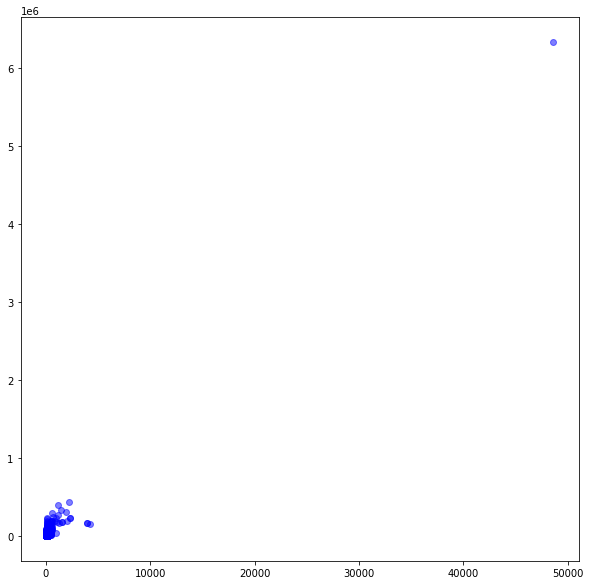

In [ ]:
plt.scatter(features_selected['OppvarmetBRA'], features_selected['BeregnetLevertEnergiElektrisitetLokaltKlima_kWh'], c='blue', alpha=0.5)
# plt.ylim(0, 2000000)

## 1-1) Remove the outliers

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

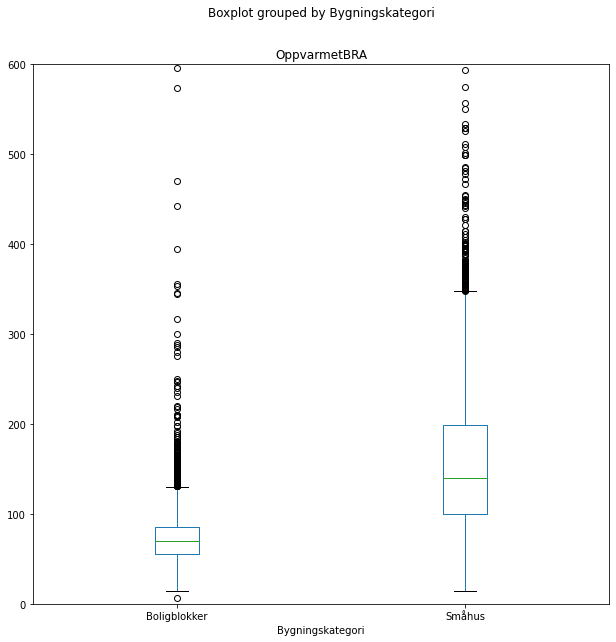

In [ ]:
plt.rcParams["figure.figsize"] = [10,10]
box = features_selected.boxplot(by = 'Bygningskategori', column =['OppvarmetBRA'], grid = False)#boxplot(column=['OppvarmetBRA'])
box
#[item.get_ydata() for item in box['whiskers']]
plt.ylim(0, 600)
plt

In [ ]:
# define a function to extract all outliers in different categories

def outliers(df, ft, subft, value):
  Q1 = df[df[ft]==subft][value].quantile(0.25)
  Q3 = df[df[ft]==subft][value].quantile(0.75)
  IQR = Q3 - Q1
  
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q1 + 1.5 * IQR

  ls = df[df[ft]==subft].index[ (df[df[ft] == subft][value] < lower_bound) | (df[df[ft] == subft][value] > upper_bound) ]
  return ls

##########################################################################################

# Define a function to Remove outliers from feature matrix
def remove(df_raw, ls):
  ls = sorted(set(ls))
  df_raw = df_raw.drop(ls)
  return df_raw


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Bygningskategori
Boligblokker    4999
Småhus          6949
Name: Bygningskategori, dtype: int64

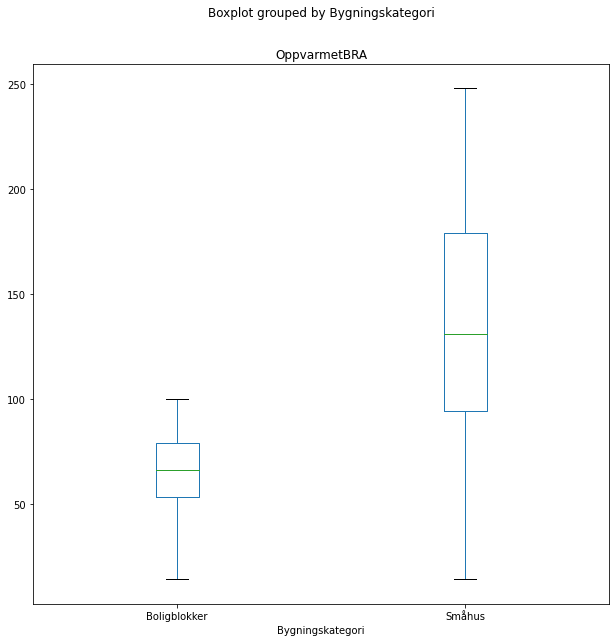

In [ ]:
# Remove outliers from input features

feature_name = 'Bygningskategori'
index_list = []
for item in features_selected[feature_name].unique():
  index_list.extend(outliers(features_selected, feature_name, item, 'OppvarmetBRA' ))

features_cleaned = remove(features_selected, index_list)
box = features_cleaned.boxplot(by = 'Bygningskategori', column =['OppvarmetBRA'], grid = False)#boxplot(column=['OppvarmetBRA'])
features_cleaned.groupby(['Bygningskategori'])['Bygningskategori'].count()

In [ ]:
################## Remove row without characteristic of 'Oppvarmingstyper' #############################
features_cleaned_ind = features_cleaned[features_cleaned['Oppvarmingstyper'] == 'Ikke data for XML'].index
features_cleaned = remove(features_cleaned,features_cleaned_ind)

################## Remove row without characteristic of 'Materialvalg' #############################
features_cleaned_ind = features_cleaned[features_cleaned['Materialvalg'] == 'Ikke data for XML'].index
features_cleaned = remove(features_cleaned,features_cleaned_ind)

## 1-333 ANOVA

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
# Convert Oppvarmingstyper to dummy variables by the use of one-hot encoding
sources = ['Elektrisitet', 'Varmepumpe', 'Ved', 'Bioenergi', 'Fjernvarme', 'Gass', 'Olje', 'Solenergi']
features_cleaned[sources] = 0
for ind in features_cleaned.index:
  temp = features_cleaned['Oppvarmingstyper'][ind].split(',')
  for item in temp:
    features_cleaned[item][ind] = 1

features_cleaned = features_cleaned.drop('Oppvarmingstyper', axis = 1)


<ipython-input-149-fa6e8693692b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_cleaned[item][ind] = 1


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[Text(0, 0, 'Residential Blocks'), Text(0, 0, 'Small House')]

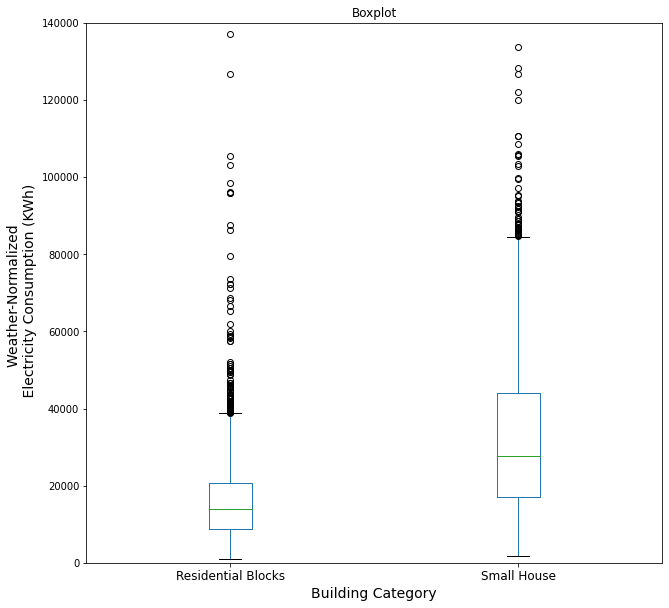

In [ ]:
# outliers of output
box = features_cleaned.boxplot(by = 'Bygningskategori', column =['BeregnetLevertEnergiElektrisitetLokaltKlima_kWh']
                               , grid = False)
plt.suptitle("")
plt.ylim(0,140000)
box.set_xlabel("Building Category", fontsize = 14)
box.set_ylabel('Weather-Normalized \n Electricity Consumption (KWh)', fontsize = 14)
box.set_title("Boxplot")
box.set_xticklabels(['Residential Blocks','Small House'],
                fontsize=12) #rotation=45


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Bygningskategori
Boligblokker    4348
Småhus          6058
Name: Bygningskategori, dtype: int64

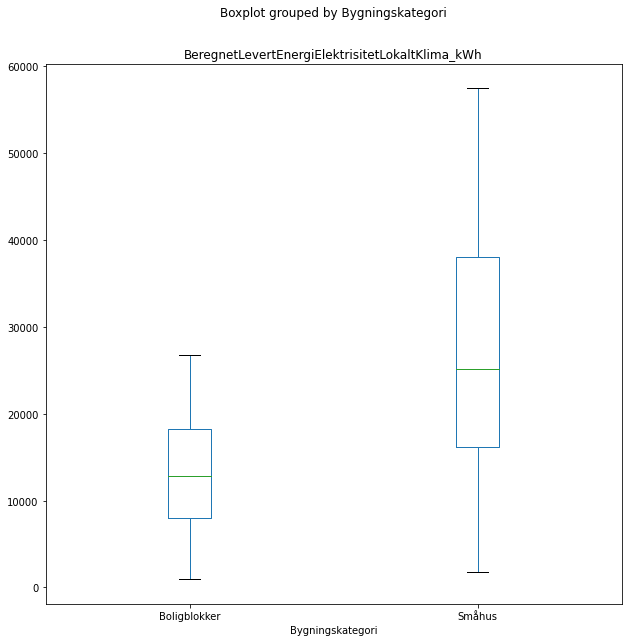

In [ ]:
# Remove outliers from output
feature_name = 'Bygningskategori'
index_list = []
for item in features_cleaned[feature_name].unique():
  index_list.extend(outliers(features_cleaned, feature_name, item, 'BeregnetLevertEnergiElektrisitetLokaltKlima_kWh' ))

features_cleaned = remove(features_cleaned, index_list)
box = features_cleaned.boxplot(by = 'Bygningskategori', column =['BeregnetLevertEnergiElektrisitetLokaltKlima_kWh'], grid = False)#boxplot(column=['OppvarmetBRA'])
features_cleaned.groupby(['Bygningskategori'])['Bygningskategori'].count()

(0.0, 60000.0)

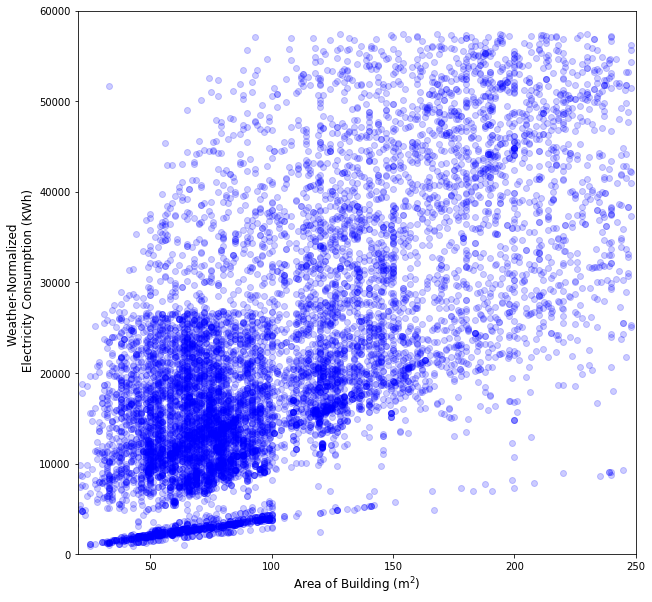

In [ ]:
plt.rcParams["figure.figsize"] = [10,10]
plt.scatter(features_cleaned['OppvarmetBRA'], features_cleaned['BeregnetLevertEnergiElektrisitetLokaltKlima_kWh'], c='blue', alpha=0.2)
plt.xlabel('Area of Building (m$^{2}$)', fontsize = 12)
plt.ylabel('Weather-Normalized \n Electricity Consumption (KWh)', fontsize = 12)
plt.xlim(20,250)
plt.ylim(0,60000)



In [ ]:
# scaler = MinMaxScaler()
std = StandardScaler()

y = features_cleaned['BeregnetLevertEnergiElektrisitetLokaltKlima_kWh'].to_numpy()
X = features_cleaned.drop('BeregnetLevertEnergiElektrisitetLokaltKlima_kWh', axis = 1)

# X_encoding = pd.get_dummies(X_selected, prefix=['coBygningskategori','Bygningstype', 'Materialvalg', 'VarmepumpeType'])
# X['Småhus'] = 
X_encoding = pd.get_dummies(X, prefix = [ 'Bygningskategori','Bygningstype', 'Materialvalg','VentilasjonssystemType', 
                                        #  'VarmepumpeType', 'VarmefordelingssystemVed',
                                         ])

X_encoding_std = std.fit_transform(X_encoding)               # standardize data
# # X_encoding_std_scaler = scaler.fit_transform(X_encoding_std) # Normalize data
# # y_scaler = scaler.fit_transform(y.reshape(-1,1))
y_scaler_std = std.fit_transform(y.reshape(-1,1))
# len(features_cleaned['VarmepumpeType'].unique())


## 1-3) Feature Selection

In [ ]:
rf = RandomForestRegressor(n_estimators = 500, random_state=0)
rf.fit(X_encoding,y_scaler_std)

<ipython-input-154-52e5d15cbdab>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_encoding,y_scaler_std)


RandomForestRegressor(n_estimators=500, random_state=0)

In [ ]:
rf.feature_importances_

array([2.03086215e-01, 1.22734307e-01, 1.63960550e-02, 4.78292095e-01,
       1.06578197e-03, 5.82473737e-03, 1.73982735e-03, 2.24063342e-04,
       6.05191637e-02, 3.18409777e-03, 3.16871398e-02, 4.33809460e-05,
       3.12568222e-02, 2.78924241e-02, 4.46688590e-06, 6.12948346e-04,
       1.52493251e-03, 4.86541452e-04, 1.13794388e-03, 2.12549130e-04,
       3.64837468e-04, 4.53390339e-04, 9.25291620e-04, 6.55941246e-04,
       1.01214486e-03, 1.00811892e-03, 6.11146760e-04, 6.42784576e-07,
       9.64675878e-04, 7.14280921e-04, 1.85664360e-03, 1.12926139e-03,
       1.88849299e-03, 4.89637683e-04])

In [ ]:
feautures_columns = ['Year of construction', 'Energy Rating', 'Heating Rating', 'Area of Building(m$^{2}$)',
                    'Heating types', 'Building Category', 'Building Type', 'Material',
                    'Ventilation System Type', 
                    #  'Heat Pump Type', 'Heat distribution system',
                     ]

feature_importance_rf = []
# rf.feature_importances_[0:2].sum
feature_importance_rf.append(rf.feature_importances_[0])
feature_importance_rf.append(rf.feature_importances_[1])
feature_importance_rf.append(rf.feature_importances_[2])
feature_importance_rf.append(rf.feature_importances_[3])
feature_importance_rf.append(rf.feature_importances_[4:12].sum())
feature_importance_rf.append(rf.feature_importances_[12:14].sum())
feature_importance_rf.append(rf.feature_importances_[14:25].sum())
feature_importance_rf.append(rf.feature_importances_[25:29].sum())
feature_importance_rf.append(rf.feature_importances_[29:].sum())
# feature_importance_rf.append(rf.feature_importances_[34:39].sum())
# feature_importance_rf.append(rf.feature_importances_[39:].sum())

<BarContainer object of 9 artists>

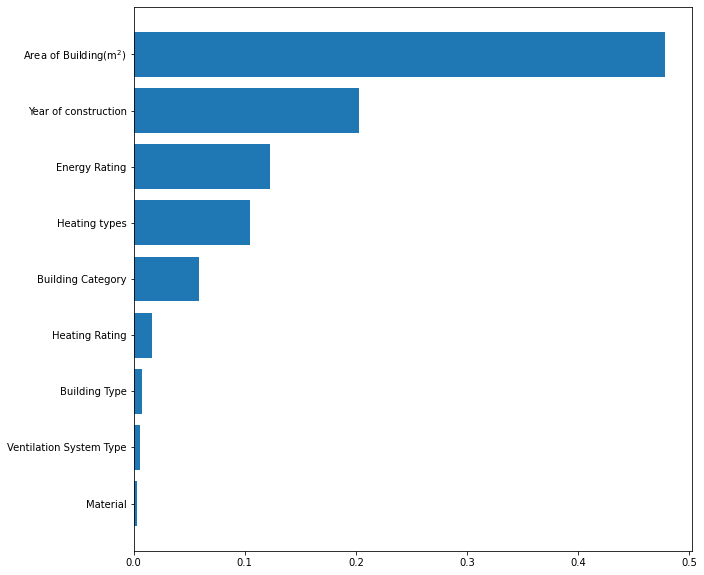

In [ ]:
f_i = list(zip(feautures_columns,feature_importance_rf))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

In [ ]:
import xgboost as xg
xgb = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 500, random_state=0)
xgb.fit(X_encoding,y_scaler_std)

XGBRegressor(n_estimators=500, objective='reg:squarederror')

In [ ]:
xgb.feature_importances_

array([0.07105825, 0.1061538 , 0.03092367, 0.1668615 , 0.00285754,
       0.00546228, 0.07564352, 0.00243242, 0.20395061, 0.02316096,
       0.08581923, 0.        , 0.14353256, 0.        , 0.        ,
       0.01076605, 0.03508753, 0.00698598, 0.00343467, 0.00033474,
       0.00186884, 0.00151536, 0.00292176, 0.00076694, 0.00161794,
       0.0017297 , 0.00071566, 0.        , 0.00290649, 0.0026524 ,
       0.00185158, 0.00243254, 0.00318398, 0.00137157], dtype=float32)

In [ ]:
feature_importance_xgb = []
feature_importance_xgb.append(xgb.feature_importances_[0])
feature_importance_xgb.append(xgb.feature_importances_[1])
feature_importance_xgb.append(xgb.feature_importances_[2])
feature_importance_xgb.append(xgb.feature_importances_[3])
feature_importance_xgb.append(xgb.feature_importances_[4:12].sum())
feature_importance_xgb.append(xgb.feature_importances_[12:14].sum())
feature_importance_xgb.append(xgb.feature_importances_[14:25].sum())
feature_importance_xgb.append(xgb.feature_importances_[25:29].sum())
feature_importance_xgb.append(xgb.feature_importances_[29:].sum())

<BarContainer object of 9 artists>

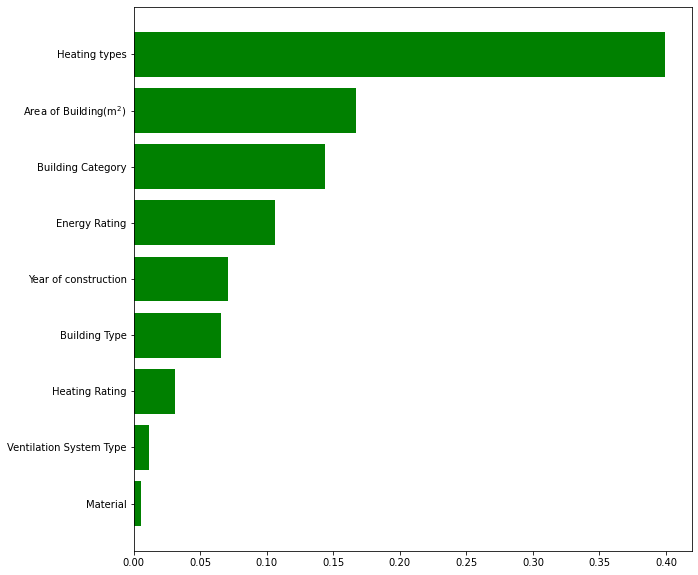

In [ ]:
f_i = list(zip(feautures_columns,feature_importance_xgb))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i], color='g')

1-2-2) Split Data in 2020 as test data

In [ ]:
# y = features_cleaned['BeregnetLevertEnergiTotaltNormalisertKlima_kWh'].to_numpy()
# X = features_cleaned.drop('BeregnetLevertEnergiTotaltNormalisertKlima_kWh', axis = 1)
# X

In [ ]:
# X['Byggeaar'].sort_values(ascending=True).unique()

## 1-2) Split Data

### 1-2-1) Split Data with `sklearn` package

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X_encoding_std, y_scaler_std, test_size=0.25, random_state=42, stratify= X_encoding['Bygningskategori_Småhus'])

# print(np.bincount(ytrain))
# print(np.bincount(ytest))
print([ytrain.shape, ytest.shape])
print([xtrain.shape, xtest.shape])


[(7804, 1), (2602, 1)]
[(7804, 34), (2602, 34)]


# 2) Linear Regression Method

## 3-1) Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(xtrain, ytrain)
y_pred_lin = linear_reg_model.predict(xtest)
MAE = mean_absolute_error(ytest, y_pred_lin)
RMSE = np.sqrt(mean_squared_error(ytest, y_pred_lin))
print('MAE  (Test Data) = %.2f'%MAE)
print('RMSE (Test Data) = %.2f'%RMSE)

MAE  (Test Data) = 0.26
RMSE (Test Data) = 0.36


In [ ]:
# dir(linear_reg_model)
print(linear_reg_model.coef_)
print(linear_reg_model.intercept_)

[[-8.23045543e-02  4.44094861e-01  6.43697514e-02  5.65375480e-01
  -5.50296947e-03 -5.60974349e-04  4.66338740e-02 -2.80881073e-02
  -1.48361720e-01 -7.31650013e-02 -2.25315886e-01 -2.21451578e-03
   2.97403468e+11  7.18249939e+11  1.77167083e+10 -5.10289796e+10
  -9.88770402e+10 -3.64497420e+10 -6.95113485e+10 -7.76499385e+09
  -3.93340864e+10  2.97159473e+11 -6.79698569e+10 -3.82992598e+10
  -7.84823018e+10  1.64124114e+11  1.14694084e+11  8.96558191e+09
   1.80062829e+11  1.59364883e+11  1.47455068e+11  1.33703113e+11
   1.82689741e+11  5.81459659e+10]]
[-0.00269455]


-200.666262041984


(0.0, 1000.0)

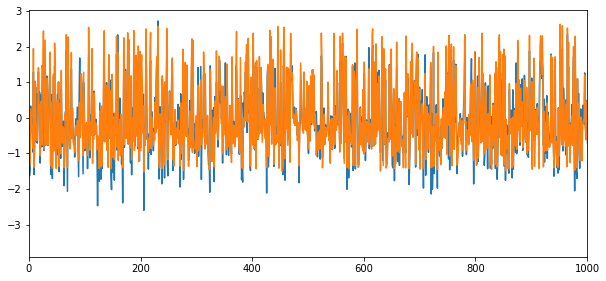

In [ ]:
ax = plt.subplot(2, 1 ,1)
plt.plot(y_pred_lin)
plt.plot(ytest)
difference = abs(ytest - y_pred_lin)/ytest * 100
print(difference.mean())
plt.xlim(0, 1000)

## 3-2) Ridge Regression Method

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RidgeCV
# help(Ridge)


In [ ]:
ridge_model = Ridge(alpha = 10, solver = 'lsqr')
ridge_model.fit(xtrain, ytrain)
y_pred_ridge = ridge_model.predict(xtest)
MAE = mean_absolute_error(ytest, y_pred_ridge)
RMSE = np.sqrt(mean_squared_error(ytest, y_pred_ridge))
print('MAE  (Test Data)= %.2f'%MAE)
print('RMSE (Test Data) = %.2f'%RMSE)

MAE  (Test Data)= 0.26
RMSE (Test Data) = 0.36


In [ ]:
# from sklearn.metrics import SCORERS
# SCORERS.keys()

In [ ]:
ridge_cv_model = RidgeCV(alphas=(0.001, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0), scoring = 'neg_mean_squared_error')
# help(RidgeCV)
ridge_cv_model.fit(xtrain, ytrain)
test_predictions_cv = ridge_cv_model.predict(xtest)
MAE = mean_absolute_error(ytest, test_predictions_cv)
RMSE = np.sqrt(mean_squared_error(ytest, test_predictions_cv))
print(ridge_cv_model.alpha_ )
print(ridge_cv_model.coef_)
print('MAE  (Test Data) = %.2f'%MAE)
print('RMSE (Test Data) = %.2f'%RMSE)


10.0
[[-8.28904455e-02  4.42322292e-01  6.49844424e-02  5.62570123e-01
  -5.20667734e-03 -2.13748579e-04  4.74686637e-02 -2.79534702e-02
  -1.47424989e-01 -7.29797810e-02 -2.24606009e-01 -2.15106837e-03
  -7.77375063e-02  7.77375063e-02 -8.22857956e-03  3.44718904e-02
   6.58527889e-02  3.94981410e-02 -1.09410671e-02 -7.18312688e-03
  -7.99278129e-03 -7.72697564e-02  1.65768296e-02  8.93178405e-03
  -5.60471614e-03 -2.56130552e-03 -2.33610348e-02  5.18908148e-03
   1.69564222e-02 -3.64933076e-02  2.28363584e-02 -5.75418836e-03
   1.79446274e-02 -1.04102687e-03]]
MAE  (Test Data) = 0.26
RMSE (Test Data) = 0.36


-201.17281881558097


(0.0, 1000.0)

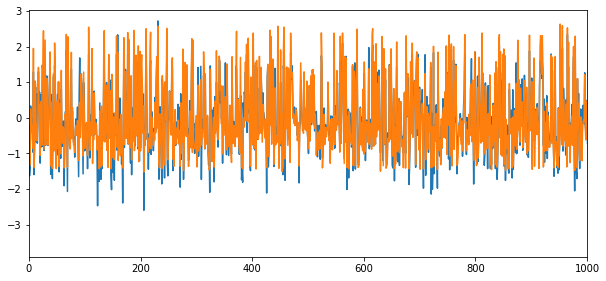

In [ ]:
ax = plt.subplot(2, 1 ,1)
plt.plot(test_predictions_cv)
plt.plot(ytest)
difference = abs(ytest - test_predictions_cv)/ytest * 100
print(difference.mean())
plt.xlim(0, 1000)

# 4) Multi Layer Perceptron (MLP)


In [ ]:
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor(hidden_layer_sizes=(60,40,40,40), activation='relu', solver='adam', alpha=0.001, random_state=1, batch_size='auto',
                    early_stopping=True, validation_fraction=0.1,max_iter=1000, n_iter_no_change=40, verbose = True, tol=0.0001).fit(xtrain, ytrain)


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.24607287
Validation score: 0.799479
Iteration 2, loss = 0.07175939
Validation score: 0.871992
Iteration 3, loss = 0.05282744
Validation score: 0.887422
Iteration 4, loss = 0.04637023
Validation score: 0.896149
Iteration 5, loss = 0.04272676
Validation score: 0.901996
Iteration 6, loss = 0.03950863
Validation score: 0.906059
Iteration 7, loss = 0.03794689
Validation score: 0.905923
Iteration 8, loss = 0.03647141
Validation score: 0.910768
Iteration 9, loss = 0.03571956
Validation score: 0.910481
Iteration 10, loss = 0.03512002
Validation score: 0.902927
Iteration 11, loss = 0.03510355
Validation score: 0.913719
Iteration 12, loss = 0.03339937
Validation score: 0.912058
Iteration 13, loss = 0.03341472
Validation score: 0.915278
Iteration 14, loss = 0.03247599
Validation score: 0.915798
Iteration 15, loss = 0.03158834
Validation score: 0.917874
Iteration 16, loss = 0.03124830
Validation score: 0.912746
Iteration 17, loss = 0.03180914
Validation score: 0.916403
Iterat

(0.0, 0.1)

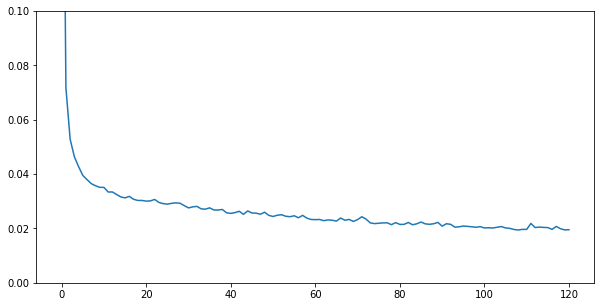

In [ ]:
plt.plot(mlp_reg.loss_curve_)
plt.ylim(0,0.1)

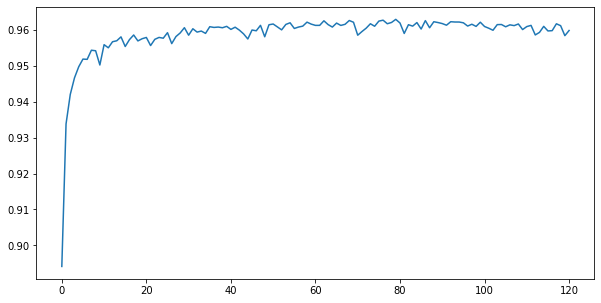

In [ ]:
mrse_val = np.sqrt(mlp_reg.validation_scores_)
mrse = np.sqrt(mlp_reg.loss_curve_)
# plt.plot(mrse)
plt.plot(mrse_val)
# plt.ylim(2000, 5000)

In [ ]:
mlp_reg .get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

### Sequential libraray

In [ ]:
# model_MLP = Sequential()
# model_MLP.add(Dense(60, activation='relu', input_shape=(20,)))        #activation='relu', 'sigmoid', default is linear activation function
# model_MLP.add(Dense(40, activation='relu'))
# model_MLP.add(Dense(40, activation='relu'))
# model_MLP.add(Dense(40, activation='relu'))
# model_MLP.add(Dense(1))

# optimizer = tf.keras.optimizers.Adam()
# model_MLP.compile(optimizer= optimizer,loss='mse',metrics=['mae'])

# # simple early stopping

# model_MLP.summary()
# plot_model(model_MLP, to_file='IMDB.png', show_shapes=True, show_layer_names=True)
# history = model_MLP.fit(x_pca_train, ytrain, epochs=500, batch_size=50, validation_split=0.1, verbose=1)#, callbacks=[es])

In [ ]:
# test_loss, test_mae = model_MLP.evaluate(x_pca_test, ytest)
# print('Test RMSE:', np.sqrt(test_loss))
# print('Test MAE:', test_mae)

In [ ]:
# test_predictions_MLP = model_MLP.predict(x_pca_test)
# difference_mlp = abs(ytest.reshape(-1,1) - test_predictions_MLP)/ytest.reshape(-1,1) * 100
# # ytest.reshape(-1,1)
# plt.plot(difference_mlp)
# print(difference_mlp.mean())
# # difference_mlp

In [ ]:
# epochs = 500
# fig, ax = plt.subplots(figsize=(10, 5))
# train_loss = np.sqrt(history.history['loss'])
# val_loss = np.sqrt(history.history['val_loss'])
# epochs = range(0,epochs)
# plt.plot(epochs, train_loss, 'g', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()
# plt.show()

# fig, ax = plt.subplots(figsize=(10, 5))
# train_acc = history.history['mae']
# val_acc = history.history['val_mae']
# plt.ylim([0, 10000])
# plt.plot(epochs, train_acc, 'g', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.grid()
# plt.show()

## 5) K nearest neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

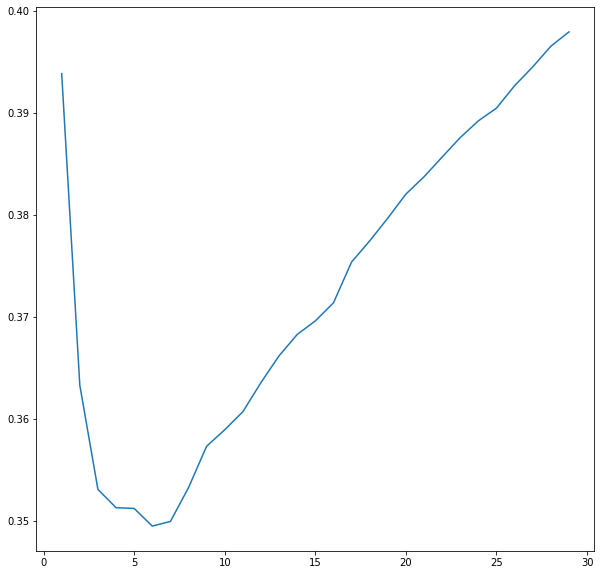

In [ ]:
test_error_rates = []
train_error_rates = []

for k in range(1,30):
  knn_model = KNeighborsRegressor(n_neighbors = k)
  # help(KNeighborsRegressor)
  knn_model.fit(xtrain, ytrain)
  
  y_pred_knn = knn_model.predict(xtest)
  yt_pred_knn = knn_model.predict(xtrain)

  RMSE_knn_train = np.sqrt(mean_squared_error(ytrain, yt_pred_knn))
  RMSE_knn_test = np.sqrt(mean_squared_error(ytest, y_pred_knn))
  train_error_rates.append(RMSE_knn_train)
  test_error_rates.append(RMSE_knn_test)

plt.plot(range(1,30), test_error_rates)
# plt.plot(range(1,30), train_error_rates)

Text(0, 0.5, 'Error of validation points')

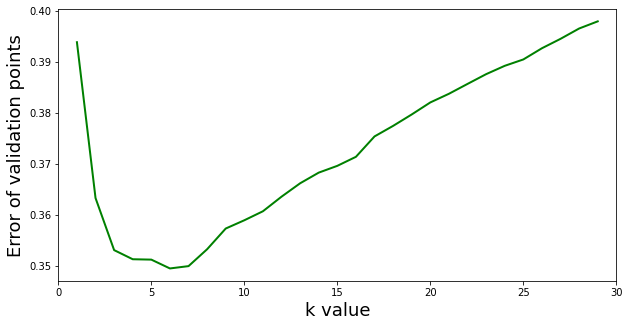

In [ ]:
plt.rcParams["figure.figsize"] = [10,5]

plt.plot(range(1,30), test_error_rates, 'g', linewidth = 2)
plt.xlim(0,30)
plt.xlabel('k value', fontsize=18)
plt.ylabel('Error of validation points', fontsize=18)
# plt.plot(range(1,30), train_error_rates)

## 5-2) Full Cross Validation Grid Search for K Value

### 5-2-1) Creating a Pipeline to find K value

**Follow along very carefully here! We use very specific string codes AND variable names here so that everything matches up correctly. This is not a case where you can easily swap out variable names for whatever you want!**

We'll use a Pipeline object to set up a workflow of operations:

1. Scale Data
2. Create Model on Scaled Data

----
*How does the Scaler work inside a Pipeline with CV? Is scikit-learn "smart" enough to understand .fit() on train vs .transform() on train and test?**

**Yes! Scikit-Learn's pipeline is well suited for this! [Full Info in Documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) **

When you use the StandardScaler as a step inside a Pipeline then scikit-learn will internally do the job for you.

What happens can be discribed as follows:

* Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
* Step 1: the scaler is fitted on the TRAINING data
* Step 2: the scaler transforms TRAINING data
* Step 3: the models are fitted/trained using the transformed TRAINING data
* Step 4: the scaler is used to transform the TEST data
* Step 5: the trained models predict using the transformed TEST data
----
*Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow on this](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

---

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
knn = KNeighborsRegressor()
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [ ]:
operation = [('knn',knn)]
pipe = Pipeline(operation)
k_values = list(range(1, 30))
##################
## scoring method:  https://scikit-learn.org/stable/modules/model_evaluation.html
param_grid = {'knn__n_neighbors':k_values}
full_cv_regressor = GridSearchCV(pipe, param_grid, cv = 5, scoring = 'neg_mean_absolute_error')
full_cv_regressor.fit(xtrain,ytrain)
full_cv_regressor.best_estimator_.get_params()

{'memory': None,
 'steps': [('knn', KNeighborsRegressor(n_neighbors=3))],
 'verbose': False,
 'knn': KNeighborsRegressor(n_neighbors=3),
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 3,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [ ]:
y_pred_knn = full_cv_regressor.predict(xtest)
knn_rmse = np.sqrt(mean_squared_error(ytest, y_pred_knn))
knn_mae = mean_absolute_error(ytest, y_pred_knn)

print(knn_rmse)
print(knn_mae)

0.35308034406148486
0.2111410041337948


## 6) Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVR,LinearSVR
from sklearn.model_selection import GridSearchCV

In [ ]:
# SVR_model.fit(xtrain, ytrain)
# y_pred_SVC = SVR_model.predict(xtest)

In [ ]:
ytrain.reshape(1,-1)[0]

array([ 0.50095797,  0.19058265, -0.24428244, ...,  2.63573777,
       -0.28244342,  0.1389302 ])

In [ ]:
SVR_model = SVR()
param_grid = {'C':[50,100, 150],
              # 'gamma':['scale', 'auto']}#,
              # 'degree':[2,3,4],
              # 'epsilon':[0, 0.01, 0.1, 0.5, 1, 2],
              }
grid = GridSearchCV(SVR_model, param_grid)
grid.fit(xtrain, ytrain.reshape(1,-1)[0])

GridSearchCV(estimator=SVR(), param_grid={'C': [50, 100, 150]})

In [ ]:
y_pred_SVC = grid.predict(xtest)
grid.best_params_

{'C': 50}

# Comparison between method

In [ ]:
y_pred_lin.reshape(1,-1)[0]
ytest

array([[-0.35431688],
       [-1.34777816],
       [-1.26502134],
       ...,
       [ 2.02813834],
       [-0.95632161],
       [ 2.10680847]])

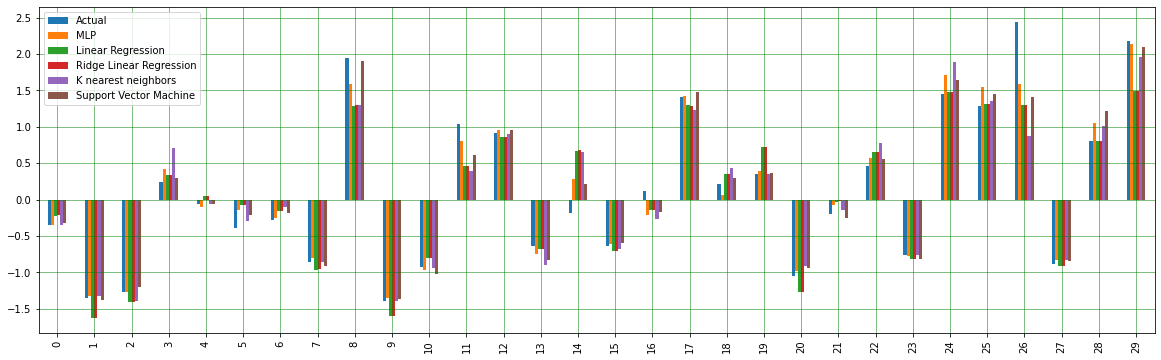

Mean Absolute Error (MLP): 0.16088626929675406
Mean Absolute Error (Linear Regression): 0.25776785149250114
Mean Absolute Error (Ridge Linear Regression): 0.25789344092680117
Mean Absolute Error (KNN method): 0.2111410041337948
Mean Absolute Error (SVM method): 0.16120497486545102
******************************************************************
Mean Squared Error(MLP): 0.06647585428755634
Mean Squared Error(Linear Regression): 0.12897183660887288
Mean Squared Error(Ridge Linear Regression): 0.12907753201006236
Mean Squared Error(KNN method): 0.12466572936257654
Mean Squared Error(SVM method): 0.07131908207253614
******************************************************************
Root Mean Squared Error (MLP): 0.25782911838571754
Root Mean Squared Error (Linear Regression): 0.3591264910987115
Root Mean Squared Error (Ridge Linear Regression): 0.35927361719177536
Root Mean Squared Error (KNN method): 0.35308034406148486
Root Mean Squared Error (SVM method): 0.2670563275276138


In [ ]:
y_pred_mlpreg = mlp_reg.predict(xtest)
df_temp = pd.DataFrame({'Actual': ytest.reshape(1,-1)[0], 'MLP': y_pred_mlpreg, 'Linear Regression':y_pred_lin.reshape(1,-1)[0],
                        'Ridge Linear Regression': y_pred_ridge.reshape(1,-1)[0], 'K nearest neighbors': y_pred_knn.reshape(1,-1)[0], 'Support Vector Machine': y_pred_SVC})
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(20,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean Absolute Error (MLP):', metrics.mean_absolute_error(ytest, y_pred_mlpreg))
print('Mean Absolute Error (Linear Regression):', metrics.mean_absolute_error(ytest, y_pred_lin))  
print('Mean Absolute Error (Ridge Linear Regression):', metrics.mean_absolute_error(ytest, y_pred_ridge))
print('Mean Absolute Error (KNN method):', metrics.mean_absolute_error(ytest, y_pred_knn))
print('Mean Absolute Error (SVM method):', metrics.mean_absolute_error(ytest, y_pred_SVC))  
print('******************************************************************')    
print('Mean Squared Error(MLP):', metrics.mean_squared_error(ytest, y_pred_mlpreg))
print('Mean Squared Error(Linear Regression):', metrics.mean_squared_error(ytest, y_pred_lin)) 
print('Mean Squared Error(Ridge Linear Regression):', metrics.mean_squared_error(ytest, y_pred_ridge))
print('Mean Squared Error(KNN method):', metrics.mean_squared_error(ytest, y_pred_knn))
print('Mean Squared Error(SVM method):', metrics.mean_squared_error(ytest, y_pred_SVC))
print('******************************************************************')    
print('Root Mean Squared Error (MLP):', np.sqrt(metrics.mean_squared_error(ytest, y_pred_mlpreg)))
print('Root Mean Squared Error (Linear Regression):', np.sqrt(metrics.mean_squared_error(ytest, y_pred_lin)))
print('Root Mean Squared Error (Ridge Linear Regression):', np.sqrt(metrics.mean_squared_error(ytest, y_pred_ridge)))
print('Root Mean Squared Error (KNN method):', np.sqrt(metrics.mean_squared_error(ytest, y_pred_knn)))
print('Root Mean Squared Error (SVM method):', np.sqrt(metrics.mean_squared_error(ytest, y_pred_SVC)))




In [ ]:
ytest

In [ ]:
y_pred_mlpreg

In [ ]:
mae_all = pd.DataFrame([])
mae_all ['MLP'] = abs(ytest.reshape(1,-1)[0] - y_pred_mlpreg)
mae_all ['lin'] = abs(ytest.reshape(1,-1)[0] - y_pred_lin.reshape(1,-1)[0])
mae_all ['ridge'] = abs(ytest.reshape(1,-1)[0] - y_pred_ridge.reshape(1,-1)[0])
mae_all ['KNN'] = abs(ytest.reshape(1,-1)[0] - y_pred_knn.reshape(1,-1)[0])
mae_all ['SVC'] = abs(ytest.reshape(1,-1)[0] - y_pred_SVC)

In [ ]:
mae_all

,MLP,lin,ridge,KNN,SVC
0,0.001864,0.134764,0.135872,0.006551,0.026628
1,0.022257,0.282358,0.279960,0.020042,0.034912
2,0.004858,0.136477,0.140696,0.126790,0.060861
3,0.173994,0.084363,0.085948,0.464239,0.049003
4,0.033002,0.106191,0.105622,0.003424,0.005396
...,...,...,...,...,...
2597,0.008034,0.103591,0.104001,0.035643,0.051161
2598,0.033384,0.062636,0.062347,0.072780,0.024317
2599,0.181255,0.102163,0.096039,0.579776,0.254217
2600,0.358226,0.019212,0.005659,0.408887,0.124791


(-0.1, 1.0)

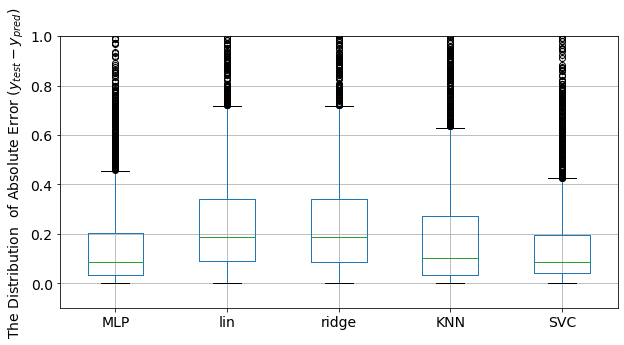

In [ ]:
box_mae = mae_all.boxplot(fontsize=14)#boxplot(column=['OppvarmetBRA'])
plt.ylabel('The Distribution  of Absolute Error ($y_{test} - y_{pred})$', fontsize = 14)
plt.ylim(-.1,1)